In [494]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [495]:
import numpy as np
import pandas as pd

In [496]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [497]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect

In [498]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [499]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [500]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [501]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [502]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [503]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [504]:
# Using the inspector to print the column names within the Measurement table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [505]:
# View what the information looks like in those columns
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [506]:
# Using the inspector to print the column names within the station table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [507]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_12 = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_12


('2017-08-23')

In [508]:
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_ago)


2016-08-23


In [509]:
# Perform a query to retrieve the data and precipitation scores
prcp_scores = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23', Measurement.date <= '2017-08-23').all()


In [510]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_scores_df = pd.DataFrame(prcp_scores, columns=['date','prcp'])
prcp_scores_df.head()

,date,prcp
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [511]:
# Sort the dataframe by date
prcp_scores_df = prcp_scores_df.sort_values(by='date',ascending= True)
prcp_scores_df = prcp_scores_df.set_index('date')
prcp_scores_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


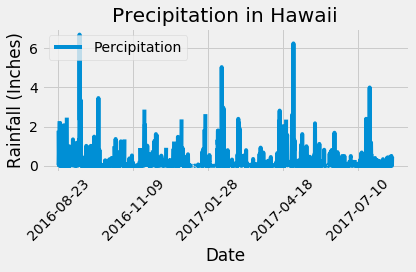

In [512]:
# Use Pandas Plotting with Matplotlib to plot the dataplt.figure(figsize = (12,6))
#plt.figure(figsize = (12,30))
prcp_scores_df.plot(rot=45)
plt.title("Precipitation in Hawaii")
plt.xlabel('Date')
plt.ylabel('Rainfall (Inches)')
plt.legend(['Percipitation'])
plt.tight_layout()
plt.savefig("images/Precipitation.png")
plt.show()


In [513]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_scores_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [514]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).\
    group_by(Measurement.station).all()


[('USC00511918'),
 ('USC00513117'),
 ('USC00514830'),
 ('USC00516128'),
 ('USC00517948'),
 ('USC00518838'),
 ('USC00519281'),
 ('USC00519397'),
 ('USC00519523')]

In [515]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [516]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.max(Measurement.tobs), 
       func.min(Measurement.tobs), 
       func.avg(Measurement.tobs)]

session.query(*sel).\
    filter(Measurement.station == 'USC00519281').all()

[(85.0, 54.0, 71.66378066378067)]

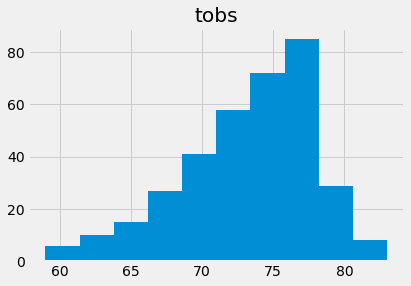

In [517]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_station = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > one_year_ago).all()

# Convert to dataframe
temp_station_df = pd.DataFrame(temp_station)

#plot histogram
temp_station_df.hist()
plt.savefig("images/Statioin_Temps.png")

## Bonus Challenge Assignment

In [518]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [519]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps('2016-08-01', '2016-08-15')
my_trip

[(71.0, 78.17525773195877, 83.0)]

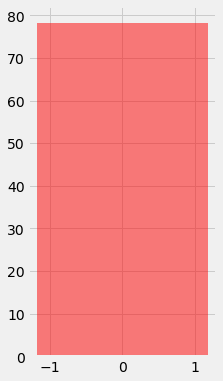

In [520]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

avg_temp = my_trip[0][1]
x_axis = np.arange(len(my_trip))


#peak-peak
lower = my_trip[0][1] - my_trip[0][0]
upper = my_trip[0][2] - my_trip[0][1]
yerr = upper - lower

#Plot bar chart
plt.figure(figsize = (3,6))
plt.bar(x_axis, avg_temp, yerr, color='r', alpha=0.5, align='center')
plt.savefig("images/TripTempSummary.png")
plt.show()


In [521]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(Measurement.station, Measurement.prcp, Station.name, Station.latitude, Station.longitude).\
    group_by(Measurement.station).\
    filter(Measurement.date > one_year_ago).\
    order_by((Measurement.prcp).desc()).all()
 


[('USC00514830', 2.28, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168),
 ('USC00519281', 2.15, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168),
 ('USC00513117', 2.15, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168),
 ('USC00516128', 1.45, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168),
 ('USC00519523', 1.22, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168),
 ('USC00519397', 0.08, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168),
 ('USC00517948', None, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168)]

In [522]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [523]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


#create a list of dates
trip_dates = ["08-01", "08-02", "08-03", "08-04", "08-05", "08-06", "08-07", "08-08", "08-09", "08-10", "08-11",
             "08-12", "08-13", "08-14", "08-15"]



#get daily normals
daily_norms = []

for trip_date in trip_dates:
    day = {}
    day['Date'] = f"2019-{trip_date}"
    daily_norm = daily_normals(trip_date)
    day['Min'] = daily_norm[0][0]
    day['Avg'] = daily_norm[0][1]
    day['Max'] = daily_norm[0][2]
    daily_norms.append(day)
    
daily_norms

[{'Date': '2019-08-01', 'Min': 67.0, 'Avg': 75.54, 'Max': 83.0},
 {'Date': '2019-08-02', 'Min': 68.0, 'Avg': 75.60377358490567, 'Max': 84.0},
 {'Date': '2019-08-03', 'Min': 70.0, 'Avg': 76.61111111111111, 'Max': 85.0},
 {'Date': '2019-08-04', 'Min': 69.0, 'Avg': 76.71153846153847, 'Max': 84.0},
 {'Date': '2019-08-05', 'Min': 69.0, 'Avg': 76.14814814814815, 'Max': 82.0},
 {'Date': '2019-08-06', 'Min': 67.0, 'Avg': 76.25, 'Max': 83.0},
 {'Date': '2019-08-07', 'Min': 71.0, 'Avg': 77.15686274509804, 'Max': 83.0},
 {'Date': '2019-08-08', 'Min': 68.0, 'Avg': 76.5576923076923, 'Max': 83.0},
 {'Date': '2019-08-09', 'Min': 69.0, 'Avg': 75.98039215686275, 'Max': 81.0},
 {'Date': '2019-08-10', 'Min': 65.0, 'Avg': 76.42, 'Max': 83.0},
 {'Date': '2019-08-11', 'Min': 67.0, 'Avg': 75.98113207547169, 'Max': 82.0},
 {'Date': '2019-08-12', 'Min': 67.0, 'Avg': 76.52727272727273, 'Max': 83.0},
 {'Date': '2019-08-13', 'Min': 71.0, 'Avg': 76.98245614035088, 'Max': 84.0},
 {'Date': '2019-08-14', 'Min': 71.0,

In [526]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

#Create a data frame
daily_norms_df = pd.DataFrame(daily_norms)

#set index
daily_norms_df.set_index('Date', inplace = True)

#display
daily_norms_df

,Min,Avg,Max
Date,,,
2019-08-01,67.0,75.540000,83.0
2019-08-02,68.0,75.603774,84.0
2019-08-03,70.0,76.611111,85.0
2019-08-04,69.0,76.711538,84.0
2019-08-05,69.0,76.148148,82.0
2019-08-06,67.0,76.250000,83.0
2019-08-07,71.0,77.156863,83.0
2019-08-08,68.0,76.557692,83.0
2019-08-09,69.0,75.980392,81.0


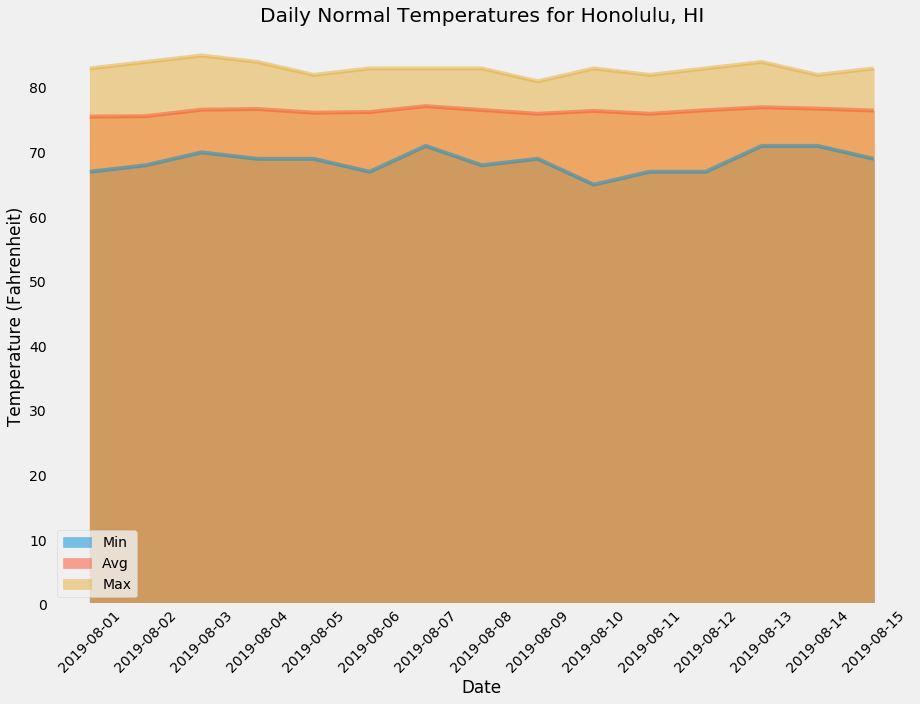

In [527]:
# Plot the daily normals as an area plot with `stacked=False`

#plot
fig, ax = plt.subplots(figsize = (13, 10))
daily_norms_df.plot.area(ax = ax, stacked = False)

#set labels
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (Fahrenheit)')
ax.set_title('Daily Normal Temperatures for Honolulu, HI')

#set ticks
dates = [f"2019-{trip_date}" for trip_date in trip_dates]
ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(dates, rotation = 45)

#save figure
plt.savefig('images/daily_normal.png')

#show
plt.grid()
plt.tight_layout()
plt.show()